In [1]:
import IP

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


underExposed_rgb = IP.imread('H:/Final Project/large/s1.jpg')
properlyExposed_rgb = IP.imread('H:/Final Project/large/s2.jpg')
overExposed_rgb = IP.imread('H:/Final Project/large/s3.jpg')

In [3]:
underExposed_rgb = IP.imread('F:/Final Project/large/people/people1.jpg')
properlyExposed_rgb = IP.imread('F:/Final Project/large/people/people2.jpg')
overExposed_rgb = IP.imread('F:/Final Project/large/people/people3.jpg')

#input

In [4]:
underExposed_rgb = IP.imread('F:/presentation/s1.jpg')
properlyExposed_rgb = IP.imread('F:/presentation/s2.jpg')
overExposed_rgb = IP.imread('F:/presentation/s3.jpg')

In [5]:
def subplot3(I1,I2,I3):
    subplot(1,3,1);imshow(I1,cmap='gray',aspect='auto');axis('off')
    subplot(1,3,2);imshow(I2,cmap='gray',aspect='auto');axis('off')
    subplot(1,3,3);imshow(I3,cmap='gray',aspect='auto');axis('off')

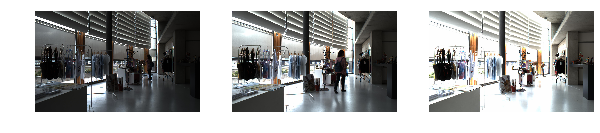

In [6]:
figure(figsize=(10,1.8))
subplot3(underExposed_rgb,properlyExposed_rgb,overExposed_rgb)

In [7]:
underExposed = IP.rgb2gray(underExposed_rgb)
properlyExposed = IP.rgb2gray(properlyExposed_rgb)
overExposed = IP.rgb2gray(overExposed_rgb)

In [8]:
underExposed_b = IP.im2bw(underExposed,median(underExposed))
properlyExposed_b = IP.im2bw(properlyExposed,median(properlyExposed))
overExposed_b = IP.im2bw(overExposed,median(overExposed))

In [9]:
def pad_zero(I):
    (height,width)=IP.shape(I)
    I_pad = zeros((height+200,width+200))
    I_pad[100:100+height,100:100+width] = I
    return(I_pad)

In [10]:
underExposed_pad = pad_zero(underExposed_b)
properlyExposed_pad = pad_zero(properlyExposed_b)
overExposed_pad = pad_zero(overExposed_b)

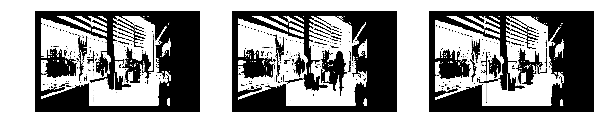

In [11]:
figure(figsize=(10,1.8))
subplot3(underExposed_pad,properlyExposed_pad,overExposed_pad)

In [12]:
imsave('MTB1.jpg',underExposed_pad,cmap='gray')
imsave('MTB2.jpg',properlyExposed_pad,cmap='gray')
imsave('MTB3.jpg',overExposed_pad,cmap='gray')

In [13]:
def downsample(I,N):
    (height,width) = IP.shape(I)
    I_downsample = zeros((height,width,N))
    I_downsample[:,:,N-1] = I #the last one is the original image
    for n in range(N-1):
        for i in range(int(height/(2**(n+1)))):
            for j in range(int(width/(2**(n+1)))):
                I_downsample[height/2-height/(2**(n+2))+i,width/2-width/(2**(n+2))+j,N-2-n] = I[i*(2**(n+1)),j*(2**(n+1))]
    return(I_downsample)

In [14]:
underExposed_down = downsample(underExposed_pad,5)
properlyExposed_down = downsample(properlyExposed_pad,5)
overExposed_down = downsample(overExposed_pad,5)

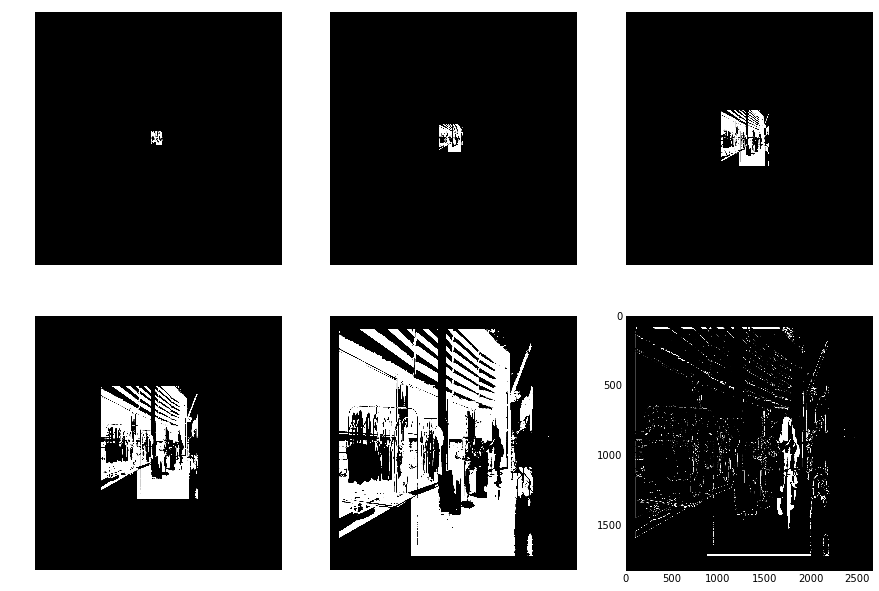

In [33]:
figure(figsize=(15,10))
for i in range(5):
    subplot(2,3,i+1);imshow(underExposed_down[:,:,i],cmap='gray',aspect='auto');axis('off')
subplot(2,3,6);imshow(underExposed_down[:,:,4]!=properlyExposed_down[:,:,4],cmap='gray',aspect='auto');axis('off')

In [34]:
imsave('down0.jpg',underExposed_down[:,:,0],cmap='gray')
imsave('down1.jpg',underExposed_down[:,:,1],cmap='gray')
imsave('down2.jpg',underExposed_down[:,:,2],cmap='gray')
imsave('down3.jpg',underExposed_down[:,:,3],cmap='gray')
imsave('down4.jpg',underExposed_down[:,:,4],cmap='gray')
imsave('xor.jpg',underExposed_down[:,:,4]!=properlyExposed_down[:,:,4],cmap='gray')

#find the translation value

In [17]:
def alignment(I1,I2):
    (height,width,N) = IP.shape(I1)
    I_align = zeros((height,width,9))
    error = zeros((9))

    offset = [-1,0,1]
    offset_get = zeros((N,2))
    trans = np.array([[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]])

    for n in range(N):
        t = 0
        for i in offset:
            for j in offset:
                T = IP.AffineTransform(translation=(i,j))
                I_align[:,:,t] = IP.warp(I2[:,:,n],T)
                error[t] = sum(I1[:,:,n]!=I_align[:,:,t])
                t = t+1
        offset_get[n,:] = trans[np.where(error == error.min())[0],:]
        if n+1 < N:
            for m in range(n+1,N):
                I2[:,:,m] = IP.warp(I2[:,:,m],IP.AffineTransform(translation=((2**(m-n))*offset_get[n,0],(2**(m-n))*offset_get[n,1])))
                
    return(offset_get)

In [18]:
(offset_12) = alignment(underExposed_down,properlyExposed_down)

In [19]:
offset_12

array([[ 0.,  1.],
       [ 0., -1.],
       [-1.,  1.],
       [ 1.,  0.],
       [-1., -1.]])

In [20]:
(offset_13)= alignment(underExposed_down,overExposed_down)

In [21]:
offset_13

array([[-1.,  1.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0., -1.],
       [ 0.,  1.]])

#crop the align image

In [22]:
def align(I1,I2,I3,offset_12,offset_13):
    (height,width,dim) = IP.shape(I1)
    N = size(offset_12,0)
    horizontal_12 = 0
    horizontal_13 = 0
    vertical_12 = 0
    vertical_13 = 0
    for i in range(N):
        horizontal_12 += offset_12[i,0]*(2**(N-i-1))
        horizontal_13 += offset_13[i,0]*(2**(N-i-1))
        vertical_12 += offset_12[i,1]*(2**(N-i-1))
        vertical_13 += offset_13[i,1]*(2**(N-i-1))
    T_12 = IP.AffineTransform(translation=(horizontal_12,vertical_12))
    T_13 = IP.AffineTransform(translation=(horizontal_13,vertical_13))
    I2_align = IP.warp(I2,T_12)
    I3_align = IP.warp(I3,T_13)
    #find the zero column and row
    I2_gray = IP.rgb2gray(I2_align)
    I3_gray = IP.rgb2gray(I3_align)
    z2_row = np.where(~I2_gray.any(axis=1))[0]
    z2_column = np.where(~I2_gray.any(axis=0))[0]
    z3_row = np.where(~I3_gray.any(axis=1))[0]
    z3_column = np.where(~I3_gray.any(axis=0))[0]
    #delete the zero column and row
    I1_resize = np.delete(I1,np.concatenate([z2_column,z3_column]),1) 
    I1_resize = np.delete(I1_resize,np.concatenate([z2_row,z3_row]),0)
    I2_resize = np.delete(I2_align,np.concatenate([z2_column,z3_column]),1) #delete the zero column
    I2_resize = np.delete(I2_resize,np.concatenate([z2_row,z3_row]),0)
    I3_resize = np.delete(I3_align,np.concatenate([z2_column,z3_column]),1) 
    I3_resize = np.delete(I3_resize,np.concatenate([z2_row,z3_row]),0)
    return(horizontal_12,vertical_12,horizontal_13,vertical_13,I1_resize,I2_resize,I3_resize)

In [23]:
(h2,v2,h3,v3,under,properly,over) = align(underExposed_rgb,properlyExposed_rgb,overExposed_rgb,offset_12,offset_13)

#translation

In [24]:
h2

-3.0

In [25]:
v2

11.0

In [26]:
h3

-16.0

In [27]:
v3

23.0

#output

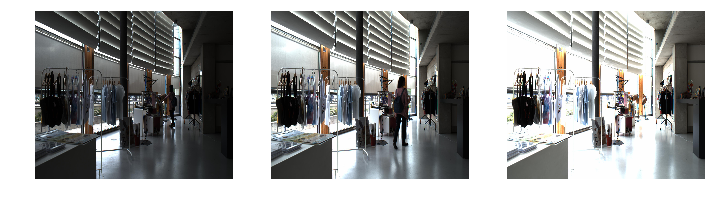

In [28]:
figure(figsize=(12,3))
subplot3(under,properly,over)

#Test the result

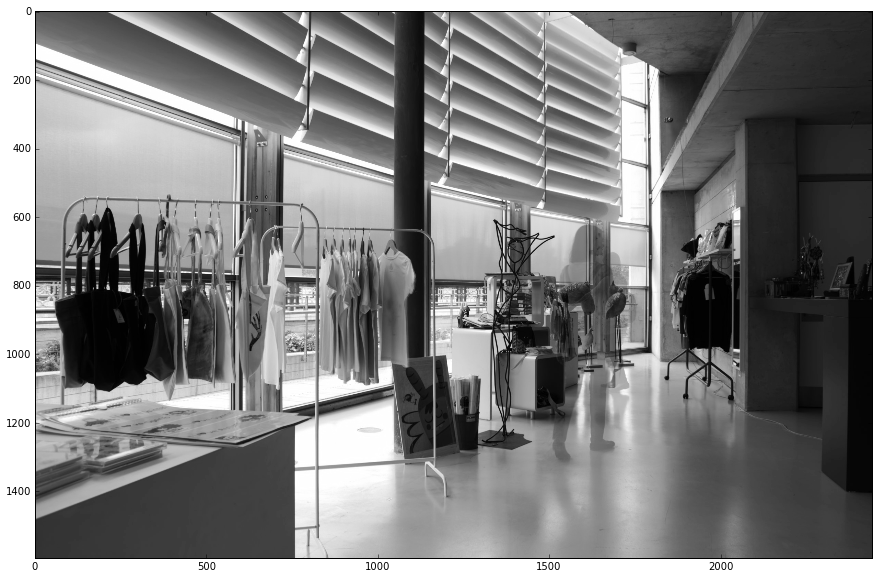

In [29]:
figure(figsize=(15,10))
imshow(IP.rgb2gray(under)+IP.rgb2gray(properly)+IP.rgb2gray(over),cmap='gray')

#unaligned image

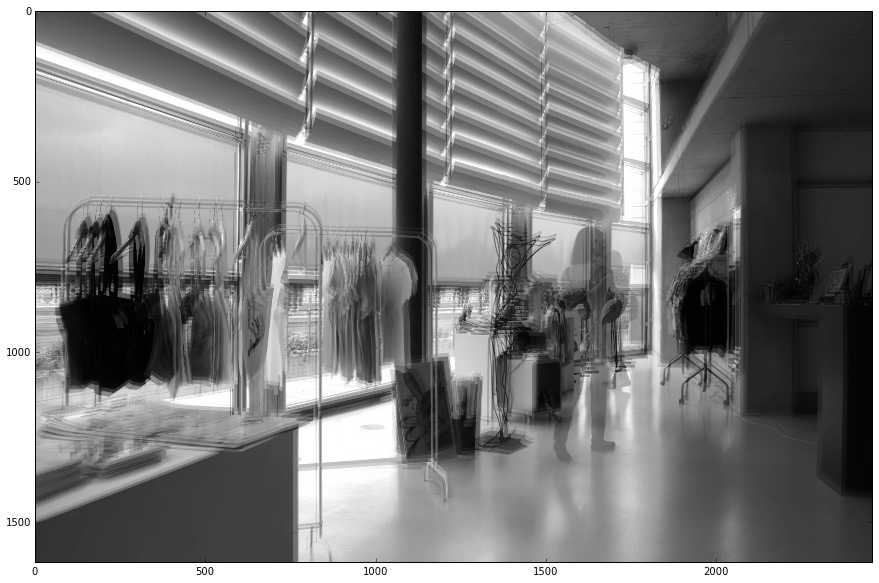

In [30]:
figure(figsize=(15,10))
imshow(underExposed+properlyExposed+overExposed,cmap='gray')

In [31]:
imsave('under.jpg',under)
imsave('properly.jpg',properly)
imsave('over.jpg',over)